In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import io
import os
import base64
from IPython.display import display, HTML, Javascript
import matplotlib.colors as mcolors

from pymatgen.core import Structure
from pymatgen.io.cif import CifWriter
from pymatgen.io.xyz import XYZ

import py3Dmol

import matplotlib.patheffects as path_effects

from decifer import (
    extract_space_group_symbol,
    space_group_symbol_to_number,
)

# ---------------------------
# Function Definitions
# ---------------------------

def rwp(sample, gen):
    """
    Calculate the Rwp (weighted-profile R-factor) between the sample and generated XRD patterns.

    Parameters:
        sample (array-like): The sample XRD intensity values.
        gen (array-like): The generated XRD intensity values.

    Returns:
        float: The Rwp value.
    """
    return np.sqrt(np.sum(np.square(sample - gen), axis=0) / np.sum(np.square(sample), axis=0))

def process_eval_file_old(eval_path, debug_max=None):
    """
    Process an evaluation file to compute Rwp values and extract relevant data.

    Parameters:
        eval_path (str): Path to the evaluation Parquet file.
        debug_max (int, optional): Maximum number of rows to process (for debugging). Defaults to None.

    Returns:
        tuple: A tuple containing:
            - rwps (np.ndarray): Array of Rwp values.
            - cif_strings (list): List of CIF strings.
            - xrd_data (list): List of tuples containing q, sample iq, and generated iq.
    """
    # Load the necessary columns from the Parquet file
    df_eval = pd.read_parquet(eval_path, columns=[
        'descriptors.xrd_gen.q',
        'descriptors.xrd_gen.iq',
        'descriptors.xrd_sample.iq',
        'validity.formula',
        'validity.bond_length',
        'validity.spacegroup',
        'validity.site_multiplicity',
        'cif_string'
    ])
    rwps = []
    cif_strings = []
    xrd_data = []

    # Define progress bar
    total_rows = len(df_eval) if debug_max is None else min(debug_max, len(df_eval))
    pbar = tqdm(total=total_rows, desc=f"Processing {os.path.basename(eval_path)}")

    for i, row in df_eval.iterrows():
        if debug_max is not None and i >= debug_max:
            break

        gen = row['descriptors.xrd_gen.iq']
        sample = row['descriptors.xrd_sample.iq']
        formula_valid = row['validity.formula']
        bond_length_valid = row['validity.bond_length']
        spacegroup_valid = row['validity.spacegroup']
        site_multiplicity_valid = row['validity.site_multiplicity']
        
        # Check validity conditions
        if np.all([formula_valid, bond_length_valid, spacegroup_valid, site_multiplicity_valid]):
            rwps.append(rwp(sample, gen))
            cif_strings.append(row['cif_string'])
            xrd_data.append((
                row['descriptors.xrd_gen.q'],
                row['descriptors.xrd_sample.iq'],
                row['descriptors.xrd_gen.iq']
            ))
        pbar.update(1)

    pbar.close()
    return np.array(rwps), cif_strings, xrd_data

def process_eval_file(eval_path, debug_max=None):
    """
    Process an evaluation file to compute Rwp and R^2 values, and extract relevant data.

    Parameters:
        eval_path (str): Path to the evaluation Parquet file.
        noise_level (float): Standard deviation of normally-distributed noise in the observed data.
        debug_max (int, optional): Maximum number of rows to process (for debugging). Defaults to None.

    Returns:
        tuple: A tuple containing:
            - rwps (np.ndarray): Array of Rwp values.
            - r^2 (np.ndarray): Array of R^2 values.
            - cif_strings (list): List of CIF strings.
            - xrd_data (list): List of tuples containing q, sample iq, and generated iq.
    """
    # Load the necessary columns from the Parquet file
    try:
        df_eval = pd.read_parquet(eval_path, columns=[
            'descriptors.xrd_gen.q',
            'descriptors.xrd_gen.iq',
            'descriptors.xrd_sample.iq',
            'validity.formula',
            'validity.bond_length',
            'validity.spacegroup',
            'validity.site_multiplicity',
            'cif_string',
        ])
    except:
        # Load the necessary columns from the Parquet file
        df_eval = pd.read_parquet(eval_path, columns=[
            'descriptors.xrd_gen_clean.q',
            'descriptors.xrd_gen_clean.iq',
            'descriptors.xrd_sample_clean.iq',
            'validity.formula',
            'validity.bond_length',
            'validity.spacegroup',
            'validity.site_multiplicity',
            'cif_string',
        ])
    
#     rwps = []
#     r2s = []
#     cif_strings = []
#     xrd_data = []
    data_list = []

    # Define progress bar
    total_rows = len(df_eval) if debug_max is None else min(debug_max, len(df_eval))
    pbar = tqdm(total=total_rows, desc=f"Processing {os.path.basename(eval_path)}", disable=True)

    for i, row in df_eval.iterrows():
        if debug_max is not None and i >= debug_max:
            break
        
        try:
            gen = row['descriptors.xrd_gen.iq']
            sample = row['descriptors.xrd_sample.iq']
        except:
            gen = row['descriptors.xrd_gen_clean.iq']
            sample = row['descriptors.xrd_sample_clean.iq']
        formula_valid = row['validity.formula']
        bond_length_valid = row['validity.bond_length']
        spacegroup_valid = row['validity.spacegroup']
        site_multiplicity_valid = row['validity.site_multiplicity']
        cif_string = row['cif_string']
        
        # Check validity conditions
        if np.all([formula_valid, bond_length_valid, spacegroup_valid, site_multiplicity_valid]):
            rwp_value = rwp(sample, gen)

            # Compute R^2 Coefficient of Determination
            residuals = sample - gen
            r2_value = 1 - np.sum(residuals**2) / np.sum((sample - np.mean(sample))**2)
            
            # Extract spacegroup number from CIF string
            spacegroup_number = space_group_symbol_to_number(extract_space_group_symbol(cif_string))
            if spacegroup_number is not None:
                spacegroup_number = int(spacegroup_number)
                
            try:
                # Append data to the list
                data_list.append({
                    'rwp': rwp_value,
                    'r2': r2_value,
                    'cif_string': cif_string,
                    'xrd_q': row['descriptors.xrd_gen.q'],
                    'xrd_sample_iq': sample,
                    'xrd_gen_iq': gen,
                    'spacegroup_number': spacegroup_number
                })
            except:
                # Append data to the list
                data_list.append({
                    'rwp': rwp_value,
                    'r2': r2_value,
                    'cif_string': cif_string,
                    'xrd_q': row['descriptors.xrd_gen_clean.q'],
                    'xrd_sample_iq': sample,
                    'xrd_gen_iq': gen,
                    'spacegroup_number': spacegroup_number
                })
        pbar.update(1)

    pbar.close()

    # Convert the data list to a DataFrame
    df_result = pd.DataFrame(data_list)
    return df_result

def generate_dynamic_colors(elements):
    """
    Generate a dictionary mapping elements to unique colors.

    Parameters:
        elements (iterable): A set or list of element symbols (str).

    Returns:
        dict: A dictionary mapping element symbols to hex color codes.
    """
    # Use seaborn color palette to generate distinct colors
    palette = sns.color_palette("husl", len(elements))
    return {element: mcolors.to_hex(color) for element, color in zip(elements, palette)}

def expand_to_supercell_xyz(cif_string, scale_matrix):
    """
    Expand a structure from a CIF string into a supercell and convert it to a DataFrame.

    Parameters:
        cif_string (str): The CIF string of the structure.
        scale_matrix (tuple): The scaling factors for the supercell (e.g., (2, 2, 2)).

    Returns:
        pandas.DataFrame: DataFrame containing atom types and coordinates in the expanded supercell.
    """
    structure = Structure.from_str(cif_string, fmt="cif")
    # Expand to supercell based on the provided scale matrix
    structure.make_supercell(scale_matrix)
    # Convert the expanded structure to XYZ format
    xyz = XYZ(structure)
    # Return the XYZ as a pandas DataFrame
    return xyz.as_dataframe()

def display_side_by_side(cif_strings, title, q, gen_list, sample_list, rwps, indices, scale_matrix=(2, 2, 2)):
    """
    Display structures side by side with their XRD patterns and histograms.

    Parameters:
        cif_strings (list of str): List of CIF strings for the structures to display.
        title (str): Title for the table and histogram.
        q (array-like): Q-values for the XRD patterns.
        gen_list (list of array-like): List of generated XRD intensity arrays.
        sample_list (list of array-like): List of sample XRD intensity arrays.
        rwps (array-like): Array of Rwp values for all structures in the dataset.
        indices (list of int): Indices of the selected structures (e.g., [min_idx, median_idx, max_idx]).
        scale_matrix (tuple, optional): Scaling factors for expanding the supercell. Defaults to (2, 2, 2).
    """
    # Prepare the HTML structure
    html_str = '''
    <table class="center">
    <tr>
    <td colspan="3"><h2 style="text-align:center;">{title}</h2></td>
    </tr>
    <tr>
    <td><h3 style="text-align:center;">{name0}</h3></td>
    <td><h3 style="text-align:center;">{name1}</h3></td>
    <td><h3 style="text-align:center;">{name2}</h3></td>
    </tr>
    <tr>
    <td id="{title}{name0}unit"></td>
    <td id="{title}{name1}unit"></td>
    <td id="{title}{name2}unit"></td>
    </tr>
    <tr>
    <td id="{title}{name0}exp"></td>
    <td id="{title}{name1}exp"></td>
    <td id="{title}{name2}exp"></td>
    </tr>
    <tr>
    <td id="{title}{name0}xrd"></td>
    <td id="{title}{name1}xrd"></td>
    <td id="{title}{name2}xrd"></td>
    </tr>
    <tr>
    <td id="{title}hist" colspan="3"></td>
    </tr>
    </table>
    '''
    name_list = ['Min Rwp', 'Median Rwp', 'Max Rwp']

    # Format the HTML string with safe IDs
    html_str = html_str.format(title=title, name0=name_list[0], name1=name_list[1], name2=name_list[2])
    display(HTML(html_str))

    js_code_list = []

    # Collect Rwp values for vertical lines in histogram
    model_rwps = []

    for idx, (cif_string, name) in enumerate(zip(cif_strings, name_list)):
        model_idx = indices[idx]
        model_rwp = rwps[model_idx]
        model_rwps.append((model_rwp, name))  # Collect Rwp values and names

        # Load the original structure (primitive cell)
        primitive_structure = Structure.from_str(cif_string, fmt="cif")

        # Get composition and spacegroup information
        composition = primitive_structure.composition.reduced_formula
        try:
            spacegroup_info = primitive_structure.get_space_group_info()
            spacegroup_symbol = spacegroup_info[0]
            spacegroup_number = spacegroup_info[1]
            spacegroup_str = f"{spacegroup_symbol} ({spacegroup_number})"
        except:
            spacegroup_str = "Unknown"

        # Expand the structure to create a supercell
        supercell_structure = primitive_structure.copy()
        supercell_structure.make_supercell((1, 1, 1))  # No expansion in this case

        # Assign unique site labels to the supercell structure
        for idx_site, site in enumerate(supercell_structure):
            site.properties['label'] = f"{site.species_string}{idx_site}"

        # Convert structures back to CIF strings using CifWriter with unique labels
        cif_writer_supercell = CifWriter(supercell_structure, symprec=0.01)
        supercell_cif_str = cif_writer_supercell.__str__()

        # Get unique elements for coloring
        unique_elements = [str(el) for el in supercell_structure.species]
        dynamic_colors = generate_dynamic_colors(set(unique_elements))

        # Visualize the unit cell
        view = py3Dmol.view(width=300, height=300)
        view.addModel(cif_string, 'cif')
        view.setStyle({'stick': {'radius': 0.1}, 'sphere': {'scale': 0.3}})
        # Add the unit cell box
        view.addUnitCell()
        # Apply dynamic colors to the atoms based on their types
        for element in set(unique_elements):
            color = dynamic_colors[element]
            view.setStyle({'elem': element}, {'sphere': {'scale': 0.3, 'color': color}})
        view.zoomTo()
        # Insert visualization using safe IDs
        view.insert(title + name + 'unit')

        # Expand the CIF to a supercell and get the XYZ as a DataFrame
        xyz_df = expand_to_supercell_xyz(cif_string, scale_matrix)

        # Convert the DataFrame back to XYZ string for visualization
        xyz_list = list(xyz_df.itertuples(index=False, name=None))
        xyz_str = f"{len(xyz_list)}\n{title}\n" + "\n".join(f"{atom[0]} {atom[1]} {atom[2]} {atom[3]}" for atom in xyz_list)

        # Visualize the expanded structure
        viewer = py3Dmol.view(width=300, height=300)
        viewer.addModel(xyz_str, 'xyz')
        viewer.setStyle({'stick': {'radius': 0.1}, 'sphere': {'scale': 0.3}})
        # Apply dynamic colors to the atoms based on their types
        for element in set(unique_elements):
            color = dynamic_colors[element]
            viewer.setStyle({'elem': element}, {'sphere': {'scale': 0.3, 'color': color}})
        viewer.zoomTo()
        # Insert visualization using safe IDs
        viewer.insert(title + name + 'exp')

        # Prepare the title string for the XRD plot
        title_str = f"Rwp: {model_rwp:.2f}, Composition: {composition}, Spacegroup: {spacegroup_str}"

        # Plot XRD patterns
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.plot(q, sample_list[idx], label='Sample')
        ax.plot(q, gen_list[idx], label='Generated')
        ax.plot(q, sample_list[idx] - gen_list[idx] - 0.5, label='Difference')
        ax.set_xlabel('Q')
        ax.set_ylabel('Intensity')
        ax.legend()
        ax.set_title(title_str, fontsize=8)
        plt.tight_layout()

        # Save the figure to a BytesIO buffer
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        plt.close(fig)

        # Encode the image to base64
        img_base64 = base64.b64encode(buf.read()).decode('utf-8')

        # Collect JavaScript code to insert the XRD image
        js_code_xrd = f"""
        var img = document.createElement('img');
        img.src = 'data:image/png;base64,{img_base64}';
        img.width = 300;
        img.height = 225;
        document.getElementById('{title}{name}xrd').appendChild(img);
        """
        js_code_list.append(js_code_xrd)

    # After the loop, plot the histogram spanning the entire row
    fig, ax = plt.subplots(figsize=(9, 3))  # Adjust the figure size as needed
    ax.hist(rwps, bins=100, alpha=0.7, density=True, color='gray')

    colors = {'Max Rwp': 'red', 'Median Rwp': 'green', 'Min Rwp': 'blue'}
    for model_rwp, name in model_rwps:
        ax.axvline(model_rwp, color=colors[name], linestyle='dashed', linewidth=2, label=name)

    ax.set_xlabel('$R_{wp}$')
    ax.set_ylabel('Density')
    ax.set_title(f'Histogram of $R_{{wp}}$ - {title}')
    ax.legend()
    plt.tight_layout()

    # Save the histogram to a BytesIO buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    plt.close(fig)

    # Encode the histogram image to base64
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')

    # Collect JavaScript code to insert the histogram image
    js_code_hist = f"""
    var img = document.createElement('img');
    img.src = 'data:image/png;base64,{img_base64}';
    img.width = 900;  // Adjust width to span the table
    img.height = 225; // Adjust height as needed
    document.getElementById('{title}hist').appendChild(img);
    """
    js_code_list.append(js_code_hist)

    # After adding all images, execute the JavaScript code
    full_js_code = "\n".join(js_code_list)
    display(Javascript(full_js_code))

In [11]:
# ---------------------------
# Main Script Execution
# ---------------------------

# Paths to different evaluation files
eval_files = {
    'un-cond + composition':
        "../cross-contamination/crystal_full_models/attn_bias_pos_reset_addcomp_5kcrystaltest.eval",
    'XRD-cond': 
        "../deep_conditioning/COND_NOPROMPT_5kcrytaltest.eval",

    'XRD-cond + composition':
        "../deep_conditioning/COND_COMP_5kcrytaltest.eval",

    'XRD-cond, composition + spacegroup':
        "../deep_conditioning/COND_COMP_SG_5kcrytaltest.eval",
    
    'CL-emb': 
        '../cl_embeddings_experiment/CLEMB_NOPROMPT_5kcrytaltest.eval',
    
    'CL-emb, composition': 
        '../cl_embeddings_experiment/CLEMB_COMP_5kcrytaltest.eval',
    
    'CL-emb, composition + spacegroup': 
        '../cl_embeddings_experiment/CLEMB_COMP_SG_5kcrytaltest.eval',
    
    'CL-emb, composition + spacegroup, 1% noise 5% broad': 
        '../cl_embeddings_experiment/CLEMB_COMP_SG_5kcrytaltest.eval',
    
    'CL-emb, composition + spacegroup, 5% noise 5% broad': 
        '../cl_embeddings_experiment/CLEMB_COMP_SG_5PCTNOISE_5PCTFWHM_5kcrytaltest.eval',
    
    'CL-emb, composition + spacegroup, 5% noise 10% broad': 
        '../cl_embeddings_experiment/CLEMB_COMP_SG_5PCTNOISE_10PCTFWHM_5kcrytaltest.eval',
    
    'CL-emb, composition + spacegroup, 0% noise 10% broad': 
        '../cl_embeddings_experiment/CLEMB_COMP_SG_NONOISE_10PCTFWHM_5kcrytaltest.eval',
    
    '.. + 0.1% noise':
        "../deep_conditioning/COND_COMP_SG_1PPTNOISE_5kcrytaltest.eval",

    '.. + 1% noise':
        "../deep_conditioning/COND_COMP_SG_1PCTNOISE_5kcrytaltest.eval",

    '.. + 3% noise':
        "../deep_conditioning/COND_COMP_SG_3PCTNOISE_5kcrytaltest.eval",

    '.. + 5% noise':
        "../deep_conditioning/COND_COMP_SG_5PCTNOISE_5kcrytaltest.eval",

    '.. + 10% noise':
        "../deep_conditioning/COND_COMP_SG_10PCTNOISE_5kcrytaltest.eval",

    '.. + 20% noise':
        "../deep_conditioning/COND_COMP_SG_20PCTNOISE_5kcrytaltest.eval",

    'Gaussian Noise':
        "../deep_conditioning/COND_COMP_SG_JUSTNOISE_5kcrytaltest.eval",
    
    'clean':
        "../deep_conditioning/COND_COMP_SG_5kcrytaltest_clean.eval",
}

In [12]:
# Process each evaluation file
df_data = {}
pbar = tqdm(total=len(eval_files), desc='Processing datasets', leave=False)
for label, eval_path in eval_files.items():
    df_result = process_eval_file(eval_path)
    df_data[label] = df_result
    pbar.update(1)
pbar.close()

Processing datasets:   0%|          | 0/19 [00:00<?, ?it/s]

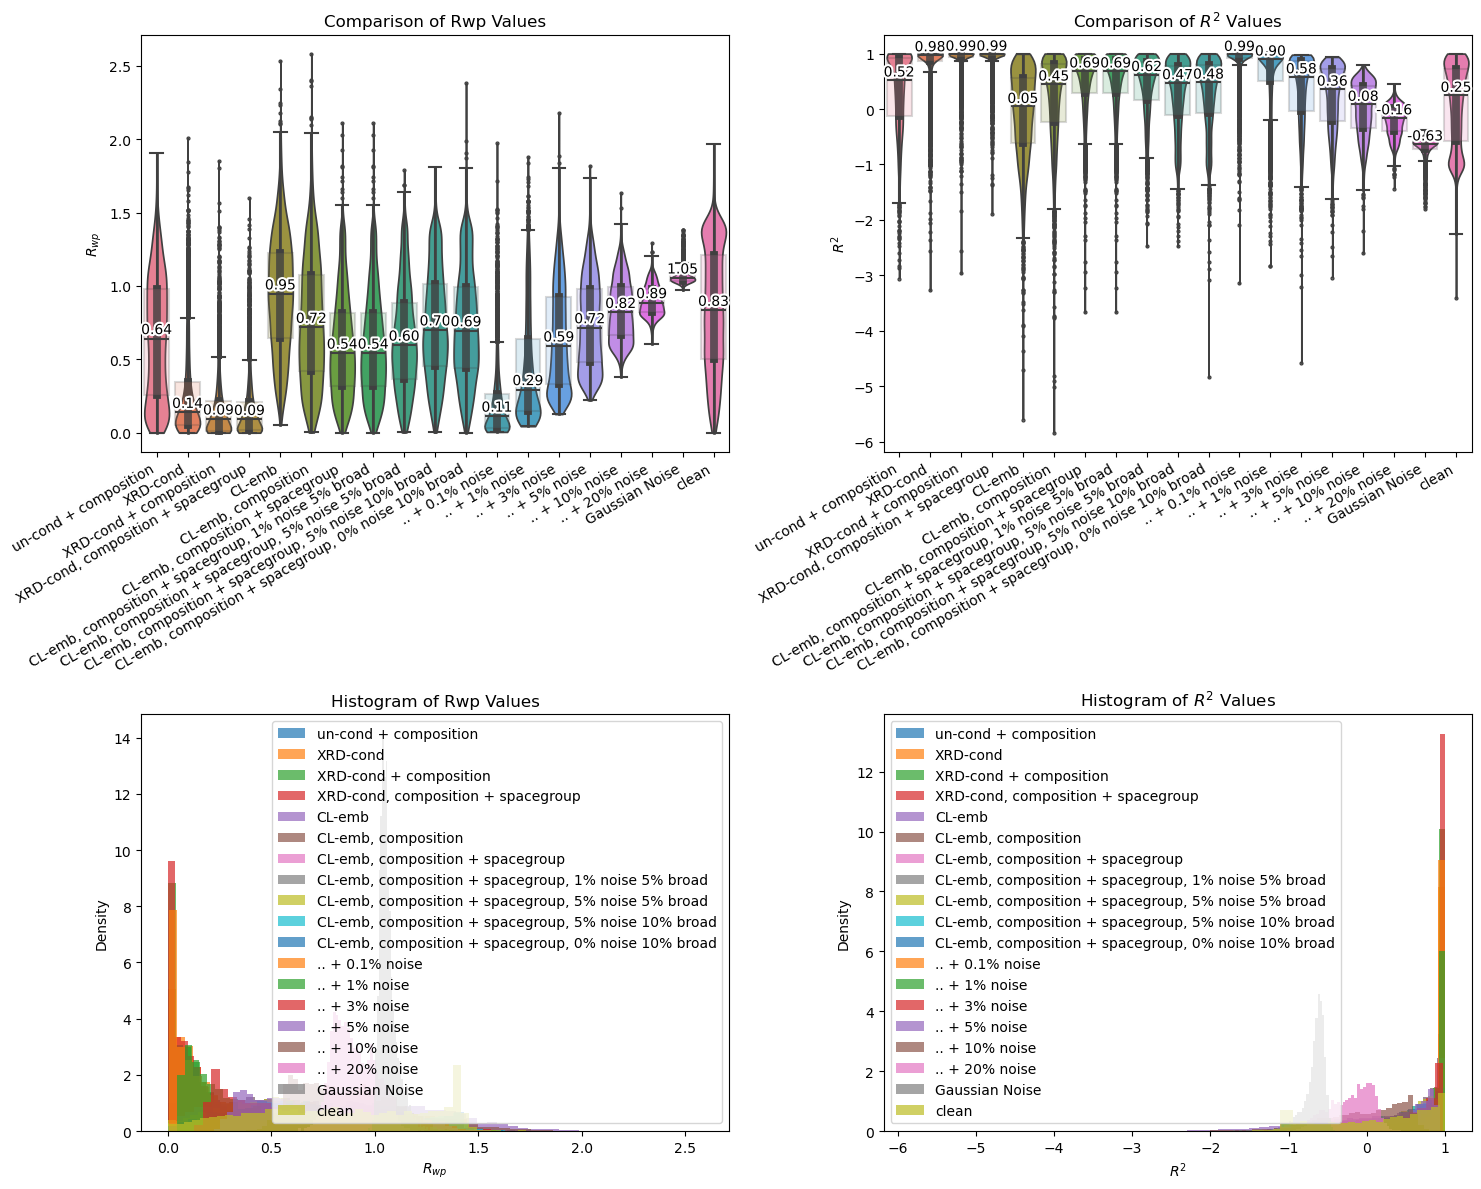

In [13]:
# Prepare data and labels
labels = list(eval_files.keys())
data_rwp = [df_data[label]['rwp'].values for label in labels]
data_r2 = [df_data[label]['r2'].values for label in labels]

# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot combined violin and boxplot for Rwp (Top-left)
sns.violinplot(data=data_rwp, cut=0, ax=axes[0, 0])
sns.boxplot(data=data_rwp, whis=1.5, fliersize=2, linewidth=1.5, 
            boxprops=dict(alpha=0.2), ax=axes[0, 0])

# Add medians to the Rwp plot
for i, label in enumerate(labels):
    med_value = np.median(df_data[label]['rwp'].values)
    text = axes[0, 0].text(i, med_value + 0.01, f'{med_value:.2f}', 
                           ha='center', va='bottom', fontsize=10, color='black')
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                           path_effects.Normal()])
axes[0, 0].set_title("Comparison of Rwp Values")
axes[0, 0].set_ylabel("$R_{wp}$")
axes[0, 0].set_xticks(np.arange(len(labels)))
axes[0, 0].set_xticklabels(labels, rotation=30, ha='right')

# Plot combined violin and boxplot for R^2 (Top-right)
sns.violinplot(data=data_r2, cut=0, ax=axes[0, 1])
sns.boxplot(data=data_r2, whis=1.5, fliersize=2, linewidth=1.5, 
            boxprops=dict(alpha=0.2), ax=axes[0, 1])

# Add medians to the R^2 plot
for i, label in enumerate(labels):
    med_value = np.median(df_data[label]['r2'].values)
    text = axes[0, 1].text(i, med_value + 0.01, f'{med_value:.2f}', 
                           ha='center', va='bottom', fontsize=10, color='black')
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                           path_effects.Normal()])
axes[0, 1].set_title(r"Comparison of $R^2$ Values")
axes[0, 1].set_ylabel(r"$R^2$")
axes[0, 1].set_xticks(np.arange(len(labels)))
axes[0, 1].set_xticklabels(labels, rotation=30, ha='right')

# Plot normalized histograms for Rwp (Bottom-left)
for label in labels:
    rwp_values = df_data[label]['rwp'].values
    axes[1, 0].hist(rwp_values, bins=50, alpha=0.7, density=True, label=label)
axes[1, 0].set_title("Histogram of Rwp Values")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()

# Plot normalized histograms for R^2 (Bottom-right)
for label in labels:
    r2_values = df_data[label]['r2'].values
    axes[1, 1].hist(r2_values, bins=50, alpha=0.7, density=True, label=label)
axes[1, 1].set_title("Histogram of $R^2$ Values")
axes[1, 1].set_ylabel("Density")
axes[1, 1].legend()

# Set xlabel only on the last row
axes[1, 0].set_xlabel("$R_{wp}$")
axes[1, 1].set_xlabel(r"$R^2$")

plt.tight_layout()
plt.show()

In [14]:
import plotly.express as px

# Define the mapping from spacegroup numbers to crystal systems
spacegroup_to_crystal_system = {
    'Triclinic': range(1, 3),      # 1-2 inclusive
    'Monoclinic': range(3, 16),    # 3-15 inclusive
    'Orthorhombic': range(16, 75), # 16-74 inclusive
    'Tetragonal': range(75, 143),  # 75-142 inclusive
    'Trigonal': range(143, 168),   # 143-167 inclusive
    'Hexagonal': range(168, 195),  # 168-194 inclusive
    'Cubic': range(195, 231)       # 195-230 inclusive
}

# Function to map spacegroup number to crystal system
def get_crystal_system(spacegroup_number):
    try:
        sg_number = int(spacegroup_number)
        for system, numbers in spacegroup_to_crystal_system.items():
            if sg_number in numbers:
                return system
        return 'Unknown'
    except (ValueError, TypeError):
        return 'Unknown'

# Collect mean Rwp for each crystal system across datasets
crystal_system_rwp_dfs = []
crystal_system_rwp_dfs_medians = []
for label in labels:
    df = df_data[label].copy()
    df = df.dropna(subset=['spacegroup_number'])
    # Map spacegroup numbers to crystal systems
    df['crystal_system'] = df['spacegroup_number'].apply(get_crystal_system)
    grouped = df.groupby('crystal_system')
    mean_rwp = grouped['rwp'].mean().reset_index()
    mean_rwp['Dataset'] = label
    median_rwp = grouped['rwp'].median().reset_index()
    median_rwp['Dataset'] = label
    crystal_system_rwp_dfs.append(mean_rwp)
    crystal_system_rwp_dfs_medians.append(median_rwp)

# Combine all datasets
combined_mean_rwp_cs = pd.concat(crystal_system_rwp_dfs)
combined_median_rwp_cs = pd.concat(crystal_system_rwp_dfs_medians)

# Ensure 'crystal_system' is ordered (optional)
crystal_system_order = ['Triclinic', 'Monoclinic', 'Orthorhombic',
                        'Tetragonal', 'Trigonal', 'Hexagonal', 'Cubic', 'Unknown']

# Plotting using Plotly
fig = px.bar(
    combined_mean_rwp_cs,
    x='crystal_system',
    y='rwp',
    color='Dataset',
    category_orders={
        'Dataset': labels,               # Enforce the order of datasets
        'crystal_system': crystal_system_order  # Enforce order of crystal systems
    },
    barmode='group',
    title='Mean Rwp per Crystal System Across Datasets'
)

fig.update_layout(
    xaxis_title='Crystal System',
    yaxis_title='Mean Rwp',
    legend_title='Dataset',
    xaxis_tickangle=-45
)

fig.show()


# Plotting using Plotly
fig = px.bar(
    combined_median_rwp_cs,
    x='crystal_system',
    y='rwp',
    color='Dataset',
    category_orders={
        'Dataset': labels,               # Enforce the order of datasets
        'crystal_system': crystal_system_order  # Enforce order of crystal systems
    },
    barmode='group',
    title='Median Rwp per Crystal System Across Datasets'
)

fig.update_layout(
    xaxis_title='Crystal System',
    yaxis_title='Mean Rwp',
    legend_title='Dataset',
    xaxis_tickangle=-45
)

fig.show()


In [16]:
import plotly.express as px

# Assuming 'combined_mean_rwp' is already defined from previous computations
# If not, compute it as follows:

# Collect mean Rwp for each spacegroup across datasets
spacegroup_rwp_dfs = []
for label in labels:
    df = df_data[label].copy()
    df = df.dropna(subset=['spacegroup_number'])
    grouped = df.groupby('spacegroup_number')
    mean_rwp = grouped['rwp'].mean().reset_index()
    mean_rwp['Dataset'] = label
    spacegroup_rwp_dfs.append(mean_rwp)

# Combine all datasets
combined_mean_rwp = pd.concat(spacegroup_rwp_dfs)

# Pivot the DataFrame for plotting
pivot_df = combined_mean_rwp.pivot(index='spacegroup_number', columns='Dataset', values='rwp')

# Reorder the columns of heatmap_data
heatmap_data = pivot_df[labels]  # Reorder columns according to 'labels'

# Ensure datasets are ordered according to 'labels'
fig = px.imshow(
    heatmap_data.T,
    labels=dict(x="Spacegroup Number", y="Dataset", color="Mean Rwp"),
    x=heatmap_data.index,
    y=labels,  # Use the ordered labels
    aspect="auto",
    color_continuous_scale='Viridis'
)

fig.update_layout(
    title='Mean Rwp per Spacegroup Across Datasets',
    yaxis={'categoryorder':'array', 'categoryarray':labels}  # Enforce dataset order
)

fig.show()


In [17]:
import plotly.express as px

# Collect counts and mean Rwp
spacegroup_stats_dfs = []
for label in labels:
    df = df_data[label].copy()
    df = df.dropna(subset=['spacegroup_number'])
    grouped = df.groupby('spacegroup_number')
    stats = grouped['rwp'].agg(['mean', 'count']).reset_index()
    stats['Dataset'] = label
    spacegroup_stats_dfs.append(stats)

# Combine all datasets
combined_spacegroup_stats = pd.concat(spacegroup_stats_dfs)

# Sort the data by spacegroup_number for consistency
combined_spacegroup_stats = combined_spacegroup_stats.sort_values('spacegroup_number')

# Create the bubble chart using Plotly
fig = px.scatter(
    combined_spacegroup_stats,
    x='spacegroup_number',
    y='mean',
    size='count',
    color='Dataset',
    category_orders={'Dataset': labels},  # Enforce the order of datasets
    hover_name='Dataset',
    title='Mean Rwp per Spacegroup Across Datasets (Bubble Size = Count)',
    labels={
        'spacegroup_number': 'Spacegroup Number',
        'mean': 'Mean Rwp',
        'count': 'Count'
    }
)

# Adjust x-axis ticks to reduce clutter
fig.update_layout(
    xaxis_title='Spacegroup Number',
    yaxis_title='Mean Rwp',
    legend_title='Dataset',
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=10,  # Set tick interval to every 10 spacegroup numbers
        range=[
            combined_spacegroup_stats['spacegroup_number'].min() - 5,
            combined_spacegroup_stats['spacegroup_number'].max() + 5
        ]
    ),
    yaxis=dict(
        range=[
            combined_spacegroup_stats['mean'].min() - 0.1,
            combined_spacegroup_stats['mean'].max() + 0.1
        ]
    )
)

# Customize the marker style
fig.update_traces(marker=dict(
    opacity=0.7,
    line=dict(width=1, color='DarkSlateGrey'),
    sizemode='area',
    sizeref=2.*max(combined_spacegroup_stats['count'])/(40.**2),
    sizemin=4  # Minimum size of the bubbles
))

fig.show()


In [18]:

# Visualize structures with lowest, highest, and median Rwp
for label in labels:
    df = df_data[label]
    rwps = df['rwp'].values
    cif_strings = df['cif_string'].values
    xrd_q = df['xrd_q'].values
    xrd_sample_iq = df['xrd_sample_iq'].values
    xrd_gen_iq = df['xrd_gen_iq'].values

    # Find the indices of the lowest, highest, and median Rwp values
    min_idx = np.argmin(rwps)
    max_idx = np.argmax(rwps)
    median_idx = np.argsort(rwps)[len(rwps) // 2]

    # Extract the corresponding CIF strings
    min_cif = cif_strings[min_idx]
    median_cif = cif_strings[median_idx]
    max_cif = cif_strings[max_idx]

    # Extract the corresponding XRD data
    q = xrd_q[0]  # Assuming q is the same for all entries
    sample_selected = [
        xrd_sample_iq[min_idx],
        xrd_sample_iq[median_idx],
        xrd_sample_iq[max_idx]
    ]
    gen_selected = [
        xrd_gen_iq[min_idx],
        xrd_gen_iq[median_idx],
        xrd_gen_iq[max_idx]
    ]

    # Pass the Rwp values and indices to the display function
    display_side_by_side(
        [min_cif, median_cif, max_cif],
        title=label,
        q=q,
        gen_list=gen_selected,
        sample_list=sample_selected,
        rwps=rwps,
        indices=[min_idx, median_idx, max_idx]
    )


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

In [1]:
# TODO
# Load dataset with conditioning
# Load model
# Generate using the conditioning

In [2]:
import os
import sys
sys.path.append("./")
import yaml

import torch
from torch.utils.data import DataLoader

import numpy as np

from decifer import (
    DeciferConfig,
    Decifer, # TODO make this DeciferModel instead
    DeciferDataset,
    Tokenizer,
    load_model_from_checkpoint,
    extract_prompt
)

In [3]:
# Create dataset
dataset_path = "../data/crystallm/1k/serialized/train.h5"
dataset = DeciferDataset(dataset_path, ["cif_tokenized", "xrd_cont.iq"])

In [4]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_path = "../deep_conditioning/ckpt.pt"
model = load_model_from_checkpoint(ckpt_path, device=device)
model.eval()
# model.train()

number of total parameters: 25.75M


Decifer(
  (transformer): ModuleDict(
    (cond_embedding): Sequential(
      (0): Linear(in_features=1000, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
    )
    (wte): Embedding(372, 512)
    (wpe): Embedding(1024, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=False)
          (c_proj): Linear(in_features=512, out_features=512, bias=False)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=512, out_features=2048, bias=False)
          (c_proj): Linear(in_features=2048, out_features=512, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): Layer

In [5]:
# model.config.condition_with_emb = False

In [6]:
model.config

DeciferConfig(block_size=1024, vocab_size=372, cond_size=1000, n_layer=8, n_head=8, n_embd=512, dropout=0.1, bias=False, lora_rank=2, use_lora=False, lora_mlp=False, lora_proj=False, condition_with_emb=True, boundary_masking=True, cond_hidden_size=256)

In [7]:
model.transformer.cond_embedding[0].weight

Parameter containing:
tensor([[ 0.0517,  0.0716,  0.0708,  ...,  0.0065, -0.0079, -0.0016],
        [ 0.0011, -0.0072, -0.0052,  ...,  0.0243,  0.0125,  0.0047],
        [-0.0192, -0.0403, -0.0431,  ...,  0.0047,  0.0058, -0.0070],
        ...,
        [-0.0282, -0.0334, -0.0196,  ..., -0.0065,  0.0081, -0.0086],
        [ 0.0043, -0.0071, -0.0205,  ...,  0.0151, -0.0077,  0.0190],
        [-0.0026,  0.0032,  0.0001,  ..., -0.0258, -0.0009,  0.0040]],
       device='cuda:0', requires_grad=True)

In [8]:
# Make decoder for tokens->CIFs
decode = Tokenizer().decode

In [9]:
import matplotlib.pyplot as plt

In [10]:
# prev_xrd = torch.zeros(1000).to(device=device)
# Sample from dataset
for i, sample in enumerate(iter(dataset)):
    cif_tokens, xrd = sample
    xrd = xrd.to(device=device)

    prompt = extract_prompt(cif_tokens, model.device, add_composition=False, add_spacegroup=False).unsqueeze(0)
    print(decode(cif_tokens.cpu().numpy()), end='\n\n')
    out = model.generate_and_print(prompt, max_new_tokens=2000, cond_vec=xrd.unsqueeze(0), start_indices_batch = [[0]])

    break
#     if i > 1:
#         break

data_Ce2N2Cl8O8
loop_
_atom_type_symbol
_atom_type_electronegativity
_atom_type_radius
_atom_type_ionic_radius
Ce 1.1200 1.8500 1.0800
N 3.0400 0.6500 0.6300
Cl 3.1600 1.0000 0.7800
O 3.4400 0.6000 1.2600
_symmetry_space_group_name_H-M P2_12_12
_cell_length_a 7.4294
_cell_length_b 11.5736
_cell_length_c 5.1258
_cell_angle_alpha 90.0000
_cell_angle_beta 90.0000
_cell_angle_gamma 90.0000
_symmetry_Int_Tables_number 18
_chemical_formula_structural CeN(ClO)4
_chemical_formula_sum 'Ce2 N2 Cl8 O8'
_cell_volume 440.7454
_cell_formula_units_Z 2
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1 'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Ce Ce0 2 0.0000 0.5000 0.5805 1.0000
N N1 2 0.0000 0.0000 0.1289 1.0000
Cl Cl2 4 0.1171 0.3165 0.1334 1.0000
Cl Cl3 4 0.2248 0.1100 0.6232 1.0000
O O4 4 0.0201 0.3732 0.8763 1.0000
O O5 4 0.1165 0.9406 0.2261 1.0000

data_Gd2Sb

In [ ]:
# prev_xrd = torch.zeros(1000).to(device=device)
# Sample from dataset
for i, sample in enumerate(iter(dataset)):
    cif_tokens, xrd = sample
    xrd = xrd.to(device=device)
    plt.hist(model.transformer.cond_embedding(xrd).cpu().detach().numpy())
    plt.show()
#     xrd_random = torch.rand_like(xrd).to(device=device)
#     prompt = extract_prompt(cif_tokens, model.device, add_composition=False, add_spacegroup=False).unsqueeze(0)
#     print(decode(cif_tokens.cpu().numpy()), end='\n\n')
#     out = model.generate_and_print(prompt, max_new_tokens=2000, cond_vec=xrd, start_indices_batch = [[0]])
#     out = model.generate_and_print(prompt, max_new_tokens=2000, cond_vec=None, start_indices_batch = [[0]])
#     ut = model.generate_and_print(prompt, max_new_tokens=2000, cond_vec=prev_xrd, start_indices_batch = [[0]])
#     prev_xrd = xrd
#     break

In [2]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

  0%|          | 0/500 [00:00<?, ?it/s]

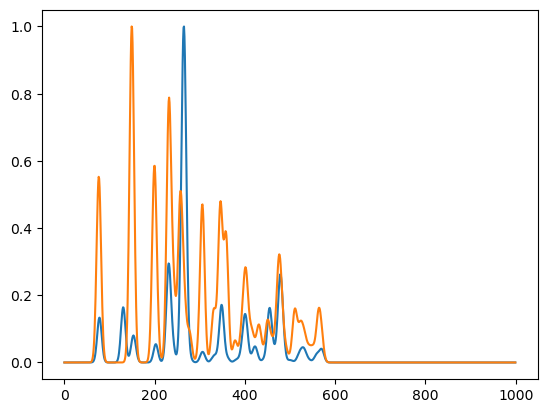

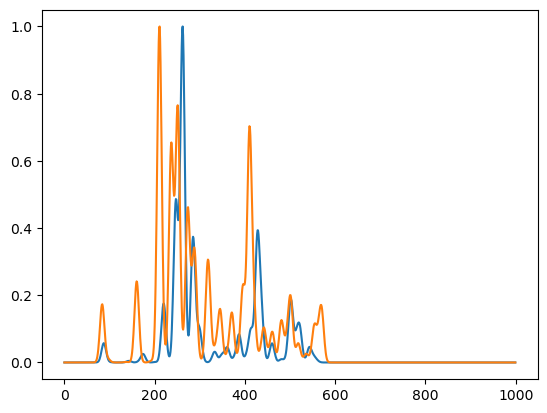

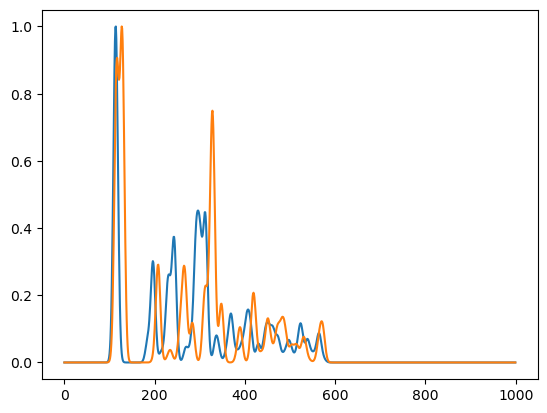

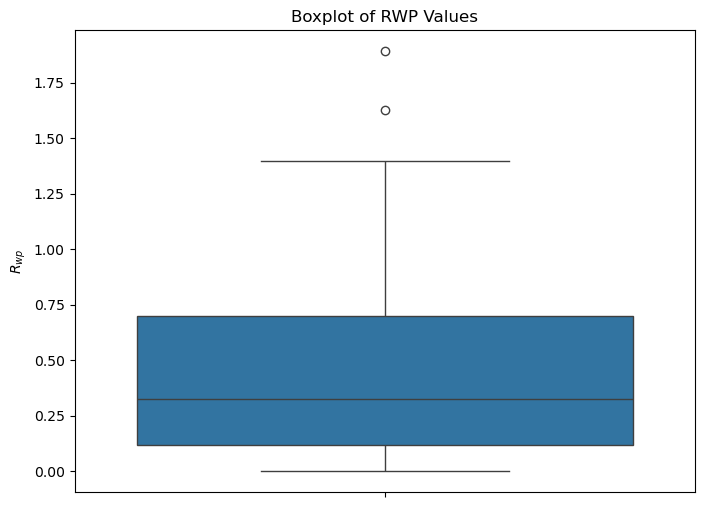

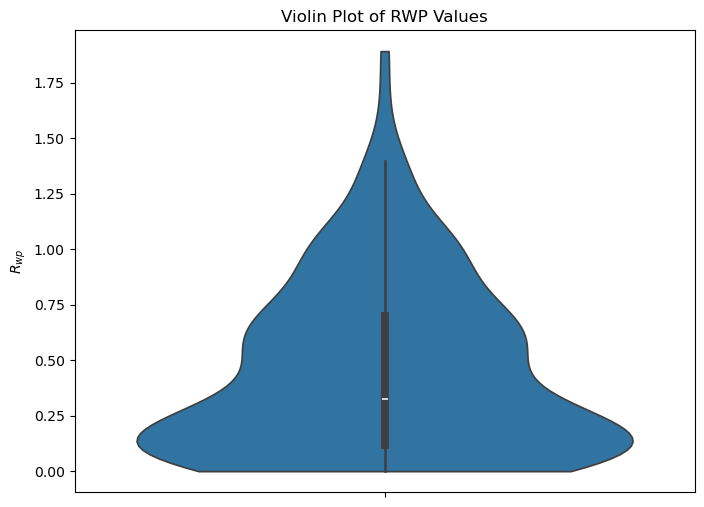

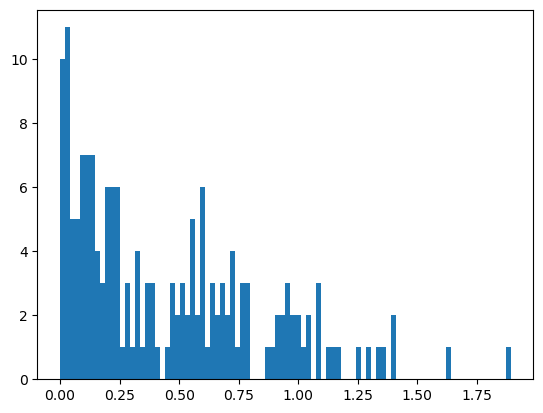

In [3]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Open eval data and compare XRD
eval_path = "../test_fullmasking_cond/cond_test.eval"
df_eval = pd.read_parquet(eval_path, columns=['descriptors.xrd_gen.iq', 'descriptors.xrd_sample.iq', 'validity.formula', 'validity.bond_length', 'validity.spacegroup', 'validity.site_multiplicity'])
df_eval

def rwp(sample, gen):
    return np.sqrt(np.sum(np.square(sample - gen), axis=0) / np.sum(np.square(sample), axis=0))

debug_max = None
rwps = []

# Define pbar based on whether debug_max is None or not
if debug_max is not None:
    pbar = tqdm(total=min(debug_max, len(df_eval)))
else:
    pbar = tqdm(total=len(df_eval))
n=0
for i, row in df_eval.iterrows():
    if debug_max is not None and i == debug_max:
        break

    gen = row['descriptors.xrd_gen.iq']
    sample = row['descriptors.xrd_sample.iq']
    formula = row['validity.formula']
    bond_length = row['validity.bond_length']
    spacegroup = row['validity.spacegroup']
    site_multiplicity = row['validity.site_multiplicity']
    
    # Check validity conditions
    if np.all([formula, bond_length, spacegroup, site_multiplicity]):
        rwps.append(rwp(sample, gen))
        
        if n < 3:
            plt.plot(sample)
            plt.plot(gen)
            plt.show()
        n += 1

    pbar.update(1)

pbar.close()

# Assuming rwps is a list of RWP values

# Convert the list to a numpy array for easier calculations
rwps_array = np.array(rwps)

# Basic statistics
mean_rwp = np.mean(rwps_array)
median_rwp = np.median(rwps_array)
std_rwp = np.std(rwps_array)
min_rwp = np.min(rwps_array)
max_rwp = np.max(rwps_array)

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn boxplot
plt.figure(figsize=(8, 6))  # Set figure size
sns.boxplot(data=rwps_array)

# Add titles and labels
plt.title("Boxplot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn violin plot
plt.figure(figsize=(8, 6))  # Set figure size
sns.violinplot(data=rwps_array, cut=0)

# Add titles and labels
plt.title("Violin Plot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

plt.hist(rwps_array, bins=90);

  0%|          | 0/500 [00:00<?, ?it/s]

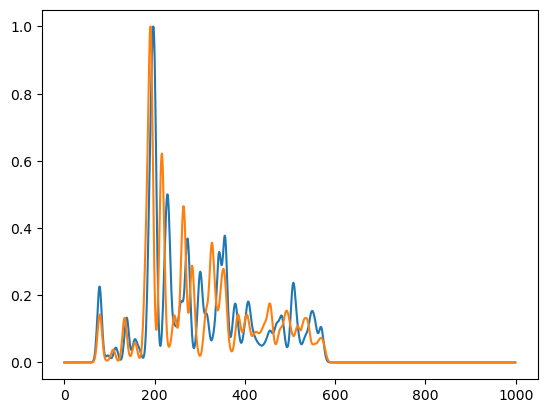

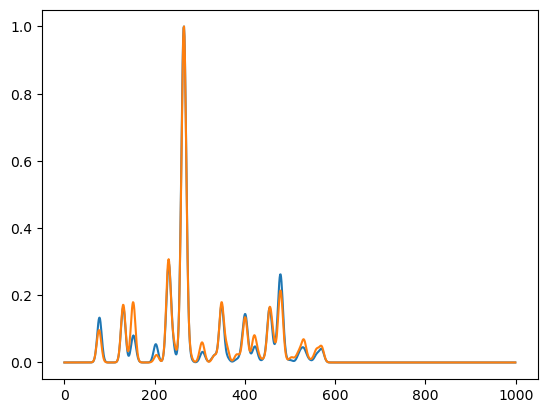

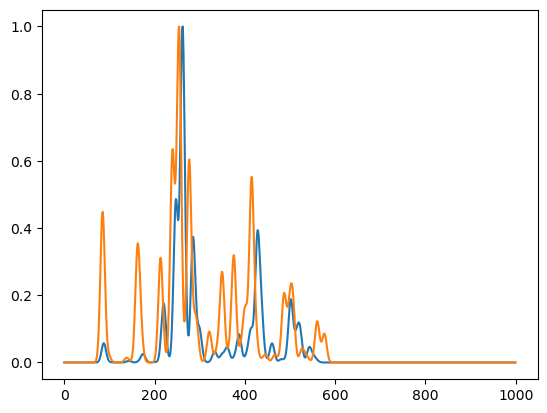

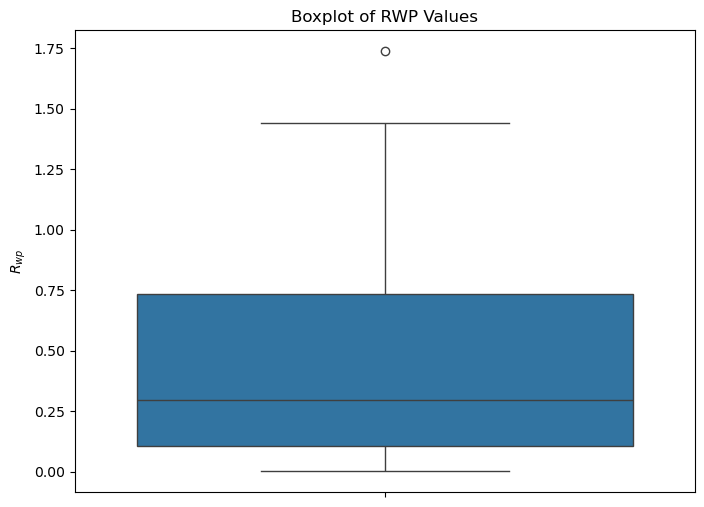

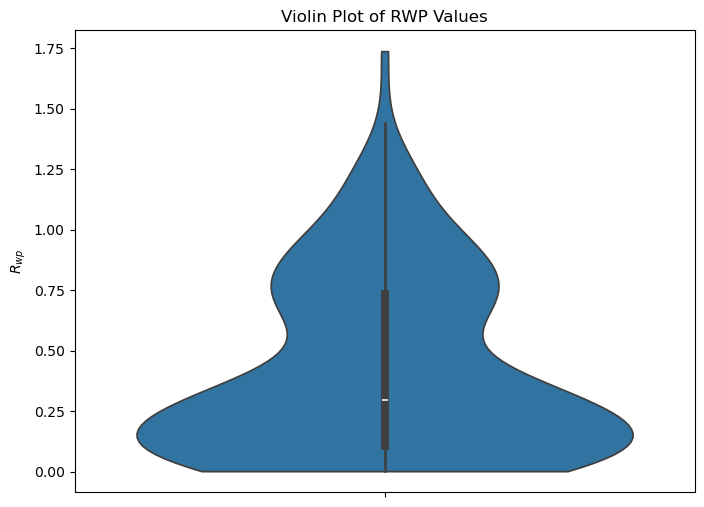

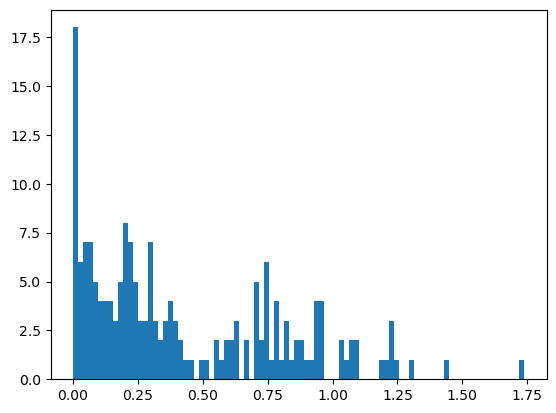

In [4]:
# Open eval data and compare XRD
eval_path = "../test_fullmasking_cond_spg/cond_test.eval"
df_eval = pd.read_parquet(eval_path, columns=['descriptors.xrd_gen.iq', 'descriptors.xrd_sample.iq', 'validity.formula', 'validity.bond_length', 'validity.spacegroup', 'validity.site_multiplicity'])
df_eval

def rwp(sample, gen):
    return np.sqrt(np.sum(np.square(sample - gen), axis=0) / np.sum(np.square(sample), axis=0))

debug_max = None
rwps = []

# Define pbar based on whether debug_max is None or not
if debug_max is not None:
    pbar = tqdm(total=min(debug_max, len(df_eval)))
else:
    pbar = tqdm(total=len(df_eval))

n = 0
for i, row in df_eval.iterrows():
    if debug_max is not None and i == debug_max:
        break

    gen = row['descriptors.xrd_gen.iq']
    sample = row['descriptors.xrd_sample.iq']
    formula = row['validity.formula']
    bond_length = row['validity.bond_length']
    spacegroup = row['validity.spacegroup']
    site_multiplicity = row['validity.site_multiplicity']
    
    # Check validity conditions
    if np.all([formula, bond_length, spacegroup, site_multiplicity]):
        rwps.append(rwp(sample, gen))
        
        if n < 3:
            plt.plot(sample)
            plt.plot(gen)
            plt.show()
            
        n += 1 

    pbar.update(1)
    

pbar.close()

# Assuming rwps is a list of RWP values

# Convert the list to a numpy array for easier calculations
rwps_array = np.array(rwps)

# Basic statistics
mean_rwp = np.mean(rwps_array)
median_rwp = np.median(rwps_array)
std_rwp = np.std(rwps_array)
min_rwp = np.min(rwps_array)
max_rwp = np.max(rwps_array)

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn boxplot
plt.figure(figsize=(8, 6))  # Set figure size
sns.boxplot(data=rwps_array)

# Add titles and labels
plt.title("Boxplot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn violin plot
plt.figure(figsize=(8, 6))  # Set figure size
sns.violinplot(data=rwps_array, cut=0)

# Add titles and labels
plt.title("Violin Plot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

plt.hist(rwps_array, bins=90);

  0%|          | 0/500 [00:00<?, ?it/s]

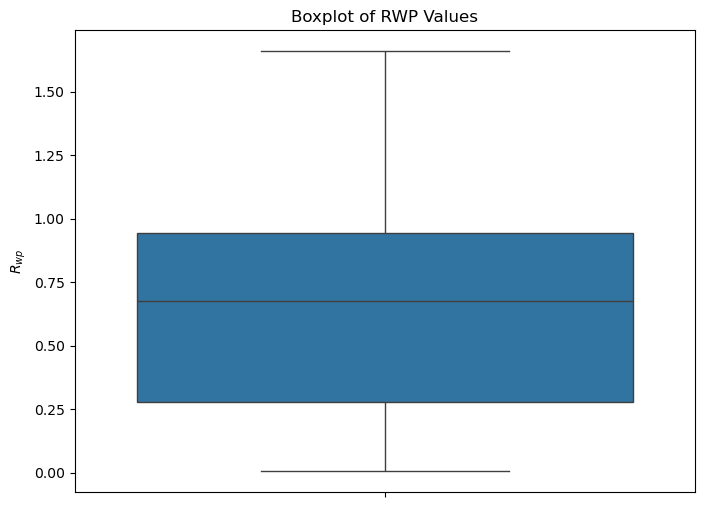

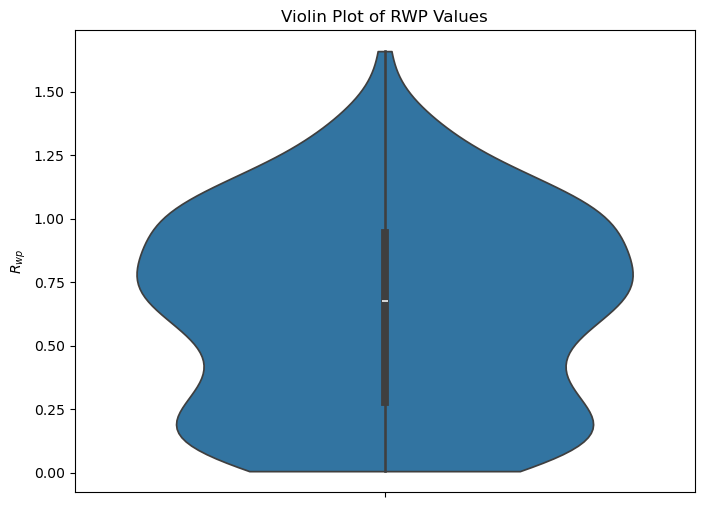

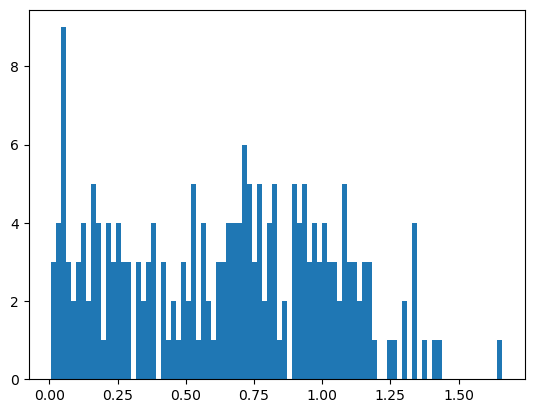

In [5]:
# Open eval data and compare XRD
eval_path = "../test_fullmasking_cond_nothing/cond_test.eval"
df_eval = pd.read_parquet(eval_path, columns=['descriptors.xrd_gen.iq', 'descriptors.xrd_sample.iq', 'validity.formula', 'validity.bond_length', 'validity.spacegroup', 'validity.site_multiplicity'])
df_eval

def rwp(sample, gen):
    return np.sqrt(np.sum(np.square(sample - gen), axis=0) / np.sum(np.square(sample), axis=0))

debug_max = None
rwps = []

# Define pbar based on whether debug_max is None or not
if debug_max is not None:
    pbar = tqdm(total=min(debug_max, len(df_eval)))
else:
    pbar = tqdm(total=len(df_eval))

for i, row in df_eval.iterrows():
    if debug_max is not None and i == debug_max:
        break

    gen = row['descriptors.xrd_gen.iq']
    sample = row['descriptors.xrd_sample.iq']
    formula = row['validity.formula']
    bond_length = row['validity.bond_length']
    spacegroup = row['validity.spacegroup']
    site_multiplicity = row['validity.site_multiplicity']
    
    # Check validity conditions
    if np.all([formula, bond_length, spacegroup, site_multiplicity]):
        rwps.append(rwp(sample, gen))
        
        if i < 3:
            plt.plot(sample)
            plt.plot(gen)
            plt.show()

    pbar.update(1)

pbar.close()

# Assuming rwps is a list of RWP values

# Convert the list to a numpy array for easier calculations
rwps_array = np.array(rwps)

# Basic statistics
mean_rwp = np.mean(rwps_array)
median_rwp = np.median(rwps_array)
std_rwp = np.std(rwps_array)
min_rwp = np.min(rwps_array)
max_rwp = np.max(rwps_array)

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn boxplot
plt.figure(figsize=(8, 6))  # Set figure size
sns.boxplot(data=rwps_array)

# Add titles and labels
plt.title("Boxplot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn violin plot
plt.figure(figsize=(8, 6))  # Set figure size
sns.violinplot(data=rwps_array, cut=0)

# Add titles and labels
plt.title("Violin Plot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

plt.hist(rwps_array, bins=90);

  0%|          | 0/500 [00:00<?, ?it/s]

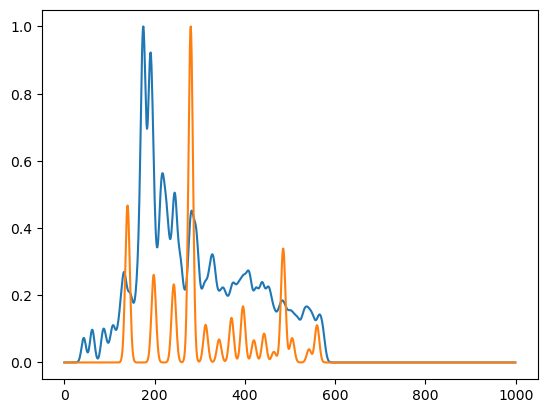

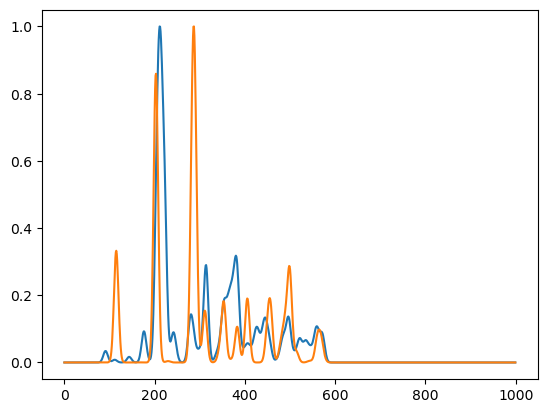

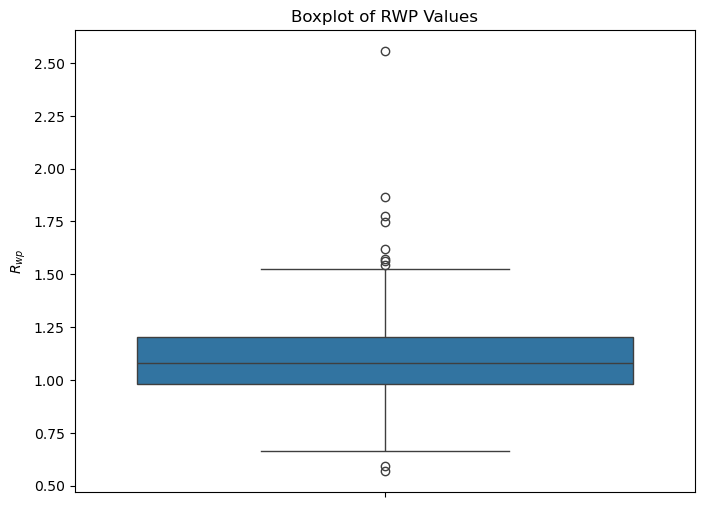

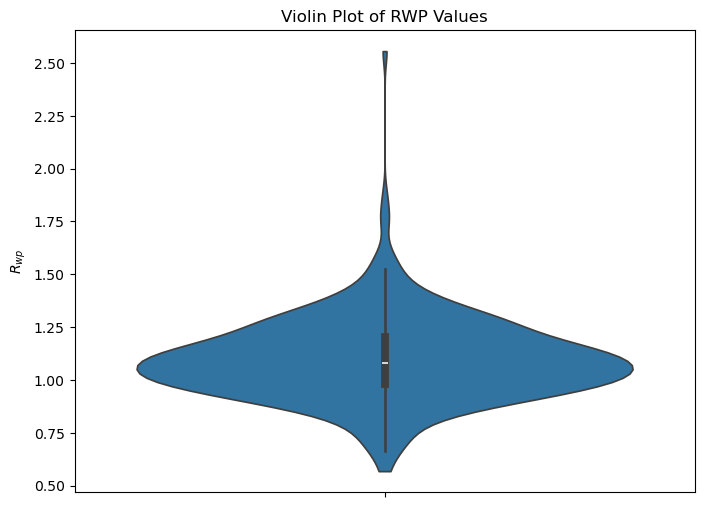

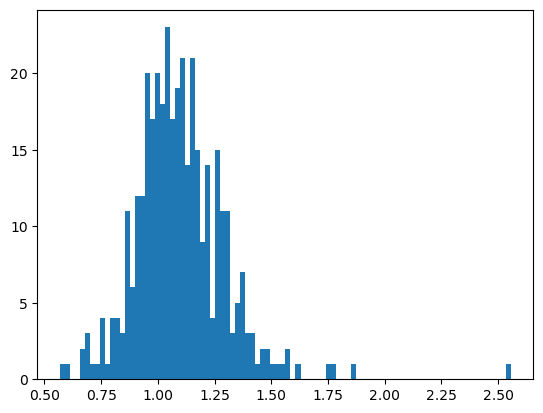

In [6]:
# Open eval data and compare XRD
eval_path = "../test_fullmasking_cond_zero/cond_test.eval"
df_eval = pd.read_parquet(eval_path, columns=['descriptors.xrd_gen.iq', 'descriptors.xrd_sample.iq', 'validity.formula', 'validity.bond_length', 'validity.spacegroup', 'validity.site_multiplicity'])
df_eval

def rwp(sample, gen):
    return np.sqrt(np.sum(np.square(sample - gen), axis=0) / np.sum(np.square(sample), axis=0))

debug_max = None
rwps = []

# Define pbar based on whether debug_max is None or not
if debug_max is not None:
    pbar = tqdm(total=min(debug_max, len(df_eval)))
else:
    pbar = tqdm(total=len(df_eval))

for i, row in df_eval.iterrows():
    if debug_max is not None and i == debug_max:
        break

    gen = row['descriptors.xrd_gen.iq']
    sample = row['descriptors.xrd_sample.iq']
    formula = row['validity.formula']
    bond_length = row['validity.bond_length']
    spacegroup = row['validity.spacegroup']
    site_multiplicity = row['validity.site_multiplicity']
    
    # Check validity conditions
    if np.all([formula, bond_length, spacegroup, site_multiplicity]):
        rwps.append(rwp(sample, gen))
        
        if i < 3:
            plt.plot(sample)
            plt.plot(gen)
            plt.show()

    pbar.update(1)

pbar.close()

# Assuming rwps is a list of RWP values

# Convert the list to a numpy array for easier calculations
rwps_array = np.array(rwps)

# Basic statistics
mean_rwp = np.mean(rwps_array)
median_rwp = np.median(rwps_array)
std_rwp = np.std(rwps_array)
min_rwp = np.min(rwps_array)
max_rwp = np.max(rwps_array)

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn boxplot
plt.figure(figsize=(8, 6))  # Set figure size
sns.boxplot(data=rwps_array)

# Add titles and labels
plt.title("Boxplot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn violin plot
plt.figure(figsize=(8, 6))  # Set figure size
sns.violinplot(data=rwps_array, cut=0)

# Add titles and labels
plt.title("Violin Plot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

plt.hist(rwps_array, bins=90);

  0%|          | 0/500 [00:00<?, ?it/s]

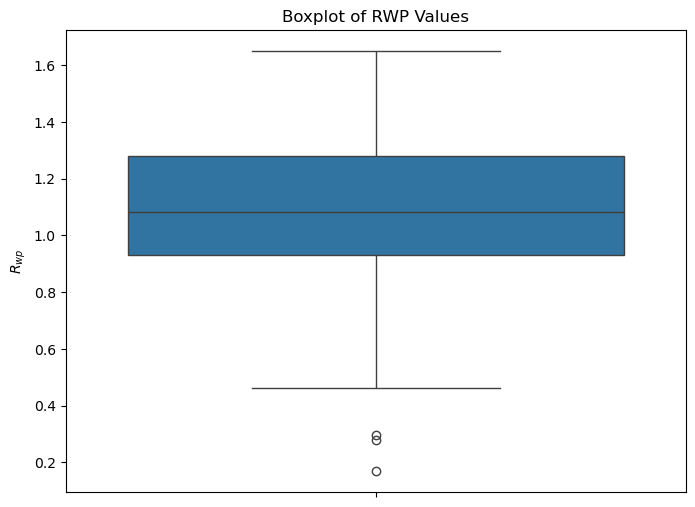

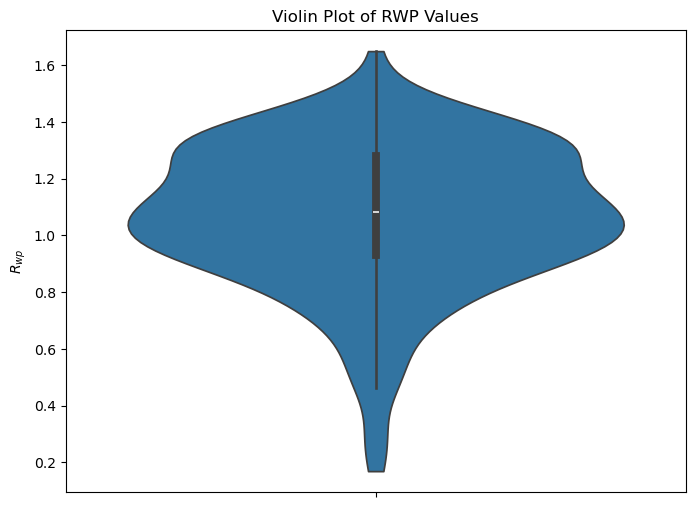

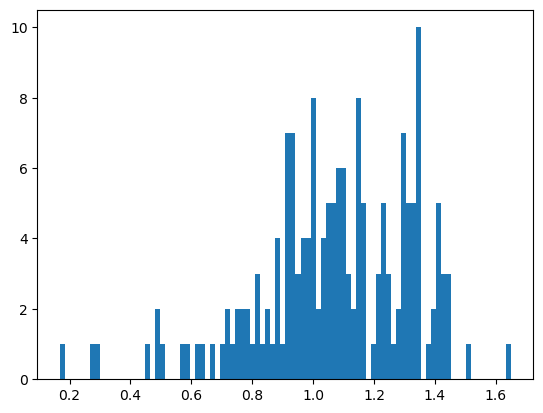

In [7]:
# Open eval data and compare XRD
eval_path = "../test_fullmasking_cond_zero_comp/cond_test.eval"
df_eval = pd.read_parquet(eval_path, columns=['descriptors.xrd_gen.iq', 'descriptors.xrd_sample.iq', 'validity.formula', 'validity.bond_length', 'validity.spacegroup', 'validity.site_multiplicity'])
df_eval

def rwp(sample, gen):
    return np.sqrt(np.sum(np.square(sample - gen), axis=0) / np.sum(np.square(sample), axis=0))

debug_max = None
rwps = []

# Define pbar based on whether debug_max is None or not
if debug_max is not None:
    pbar = tqdm(total=min(debug_max, len(df_eval)))
else:
    pbar = tqdm(total=len(df_eval))

for i, row in df_eval.iterrows():
    if debug_max is not None and i == debug_max:
        break

    gen = row['descriptors.xrd_gen.iq']
    sample = row['descriptors.xrd_sample.iq']
    formula = row['validity.formula']
    bond_length = row['validity.bond_length']
    spacegroup = row['validity.spacegroup']
    site_multiplicity = row['validity.site_multiplicity']
    
    # Check validity conditions
    if np.all([formula, bond_length, spacegroup, site_multiplicity]):
        rwps.append(rwp(sample, gen))
        
        if i < 3:
            plt.plot(sample)
            plt.plot(gen)
            plt.show()

    pbar.update(1)

pbar.close()

# Assuming rwps is a list of RWP values

# Convert the list to a numpy array for easier calculations
rwps_array = np.array(rwps)

# Basic statistics
mean_rwp = np.mean(rwps_array)
median_rwp = np.median(rwps_array)
std_rwp = np.std(rwps_array)
min_rwp = np.min(rwps_array)
max_rwp = np.max(rwps_array)

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn boxplot
plt.figure(figsize=(8, 6))  # Set figure size
sns.boxplot(data=rwps_array)

# Add titles and labels
plt.title("Boxplot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn violin plot
plt.figure(figsize=(8, 6))  # Set figure size
sns.violinplot(data=rwps_array, cut=0)

# Add titles and labels
plt.title("Violin Plot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

plt.hist(rwps_array, bins=90);

  0%|          | 0/5000 [00:00<?, ?it/s]

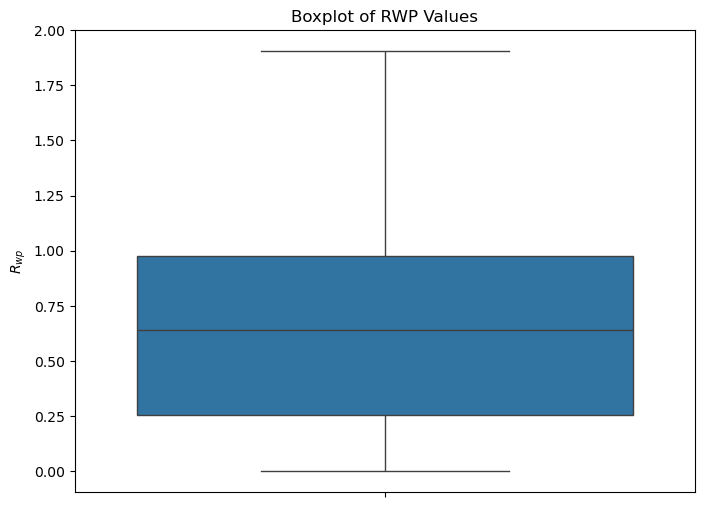

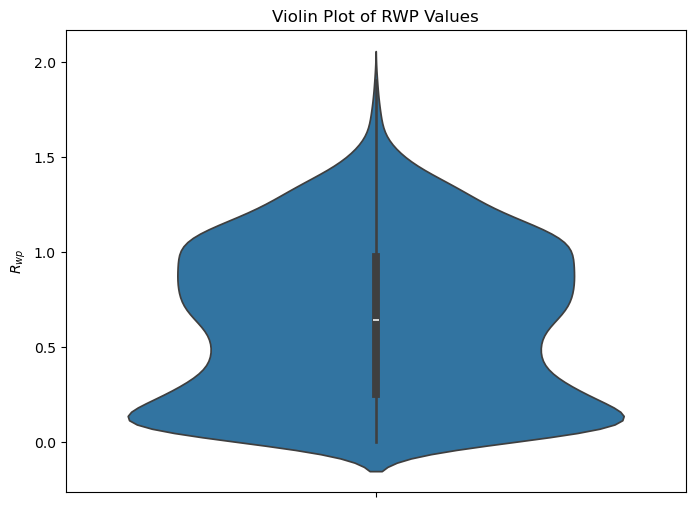

In [8]:
# Open eval data and compare XRD
eval_path = "../cross-contamination/crystal_full_models/attn_bias_pos_reset_addcomp_5kcrystaltest.eval"
df_eval = pd.read_parquet(eval_path, columns=['descriptors.xrd_gen.iq', 'descriptors.xrd_sample.iq', 'validity.formula', 'validity.bond_length', 'validity.spacegroup', 'validity.site_multiplicity'])
df_eval

def rwp(sample, gen):
    return np.sqrt(np.sum(np.square(sample - gen), axis=0) / np.sum(np.square(sample), axis=0))

debug_max = None
rwps = []

# Define pbar based on whether debug_max is None or not
if debug_max is not None:
    pbar = tqdm(total=min(debug_max, len(df_eval)))
else:
    pbar = tqdm(total=len(df_eval))

for i, row in df_eval.iterrows():
    if debug_max is not None and i == debug_max:
        break

    gen = row['descriptors.xrd_gen.iq']
    sample = row['descriptors.xrd_sample.iq']
    formula = row['validity.formula']
    bond_length = row['validity.bond_length']
    spacegroup = row['validity.spacegroup']
    site_multiplicity = row['validity.site_multiplicity']
    
    # Check validity conditions
    if np.all([formula, bond_length, spacegroup, site_multiplicity]):
        rwps.append(rwp(sample, gen))
#         plt.plot(sample)
#         plt.plot(gen)
#         plt.show()

    pbar.update(1)

pbar.close()

# Assuming rwps is a list of RWP values

# Convert the list to a numpy array for easier calculations
rwps_array = np.array(rwps)

# Basic statistics
mean_rwp = np.mean(rwps_array)
median_rwp = np.median(rwps_array)
std_rwp = np.std(rwps_array)
min_rwp = np.min(rwps_array)
max_rwp = np.max(rwps_array)

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn boxplot
plt.figure(figsize=(8, 6))  # Set figure size
sns.boxplot(data=rwps_array)

# Add titles and labels
plt.title("Boxplot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn violin plot
plt.figure(figsize=(8, 6))  # Set figure size
sns.violinplot(data=rwps_array)

# Add titles and labels
plt.title("Violin Plot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

In [3]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Open eval data and compare XRD
eval_path = "../test_fullmasking_cond/cond_test.eval"
df_eval = pd.read_parquet(eval_path)#, columns=['descriptors.xrd_gen.iq', 'descriptors.xrd_sample.iq', 'validity.formula', 'validity.bond_length', 'validity.spacegroup', 'validity.site_multiplicity'])
print(df_eval)

def rwp(sample, gen):
    return np.sqrt(np.sum(np.square(sample - gen), axis=0) / np.sum(np.square(sample), axis=0))

debug_max = None
rwps = []

# Define pbar based on whether debug_max is None or not
if debug_max is not None:
    pbar = tqdm(total=min(debug_max, len(df_eval)))
else:
    pbar = tqdm(total=len(df_eval))

for i, row in df_eval.iterrows():
    if debug_max is not None and i == debug_max:
        break

    gen = row['descriptors.xrd_gen.iq']
    sample = row['descriptors.xrd_sample.iq']
    formula = row['validity.formula']
    bond_length = row['validity.bond_length']
    spacegroup = row['validity.spacegroup']
    site_multiplicity = row['validity.site_multiplicity']
    
    # Check validity conditions
    if np.all([formula, bond_length, spacegroup, site_multiplicity]):
        rwps.append(rwp(sample, gen))
#         plt.plot(sample)
#         plt.plot(gen)
#         plt.show()

    pbar.update(1)

pbar.close()

# Assuming rwps is a list of RWP values

# Convert the list to a numpy array for easier calculations
rwps_array = np.array(rwps)

# Basic statistics
mean_rwp = np.mean(rwps_array)
median_rwp = np.median(rwps_array)
std_rwp = np.std(rwps_array)
min_rwp = np.min(rwps_array)
max_rwp = np.max(rwps_array)

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn boxplot
plt.figure(figsize=(8, 6))  # Set figure size
sns.boxplot(data=rwps_array)

# Add titles and labels
plt.title("Boxplot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn violin plot
plt.figure(figsize=(8, 6))  # Set figure size
sns.violinplot(data=rwps_array)

# Add titles and labels
plt.title("Violin Plot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

   status                                          error_msg  index  rep
0   error  could not extract space group from:\n_symmetry...     12    0
1    fail                                               None     15    0
2    fail                                               None     10    0
3   error  could not extract space group from:\n_symmetry...     16    0
4   error  could not extract space group from:\ndata_K8Na...      3    0
5    fail                                               None      7    0
6    fail                                               None      1    0
7   error  could not extract space group from:\ndata_Ba8Z...      8    0
8    fail                                               None      4    0
9   error  could not extract space group from:\ndata_Sr8C...     14    0
10   fail                                               None      0    0
11   fail                                               None      5    0
12  error  could not extract space group from:\ndat

  0%|          | 0/20 [00:00<?, ?it/s]

KeyError: 'descriptors.xrd_gen.iq'